# Which GA Campus is Most Happening?

### 3/10/17 | [Brendan Bailey](http://brendanbailey.github.io/)

One of the most valuable services GA provides are events. Events provide opportunities for networking enabling you to find your next job, team member, investor, or to just keep in the know.

The following script scrapes the GA website event pages for each location (except Torontos since they're run by BitMaker), and shows which location has the most upcoming events.

In [1]:
#imports all relevant libraries for the script
%matplotlib inline
from bs4 import BeautifulSoup
import pandas as pd
import requests, json
import numpy as np
import matplotlib.pyplot as plt

The following function takes any location input, and scrapes the corresponding GA location page. Specifically it parses out the event data JSON, which contains information about the event names, dates, site urls, and more. The function returns a data frame for that specific GA campus.

In [2]:
#Function to scrape GA site
def scrape_ga(location):
    error_dict = {}
    #Prepares URL to be scraped http://www.pythonforbeginners.com/python-on-the-web/web-scraping-with-beautifulsoup/
    url = "https://generalassemb.ly/education?where=%s" % (location)
    r = requests.get(url)
    data = r.text
    soup = BeautifulSoup(data, 'html.parser')
    
    #Creates a list of dictionaries based on site's JSON. Data captured is event title, date, event format, url, city
    dataframe_list = []
    for item in soup.find_all("script"):
        if "window.EDUCATIONAL_OFFERINGS_JSON" in str(item):
            json_list = str(item).split(";\n")
            for item in json_list:
                if "window.EDUCATIONAL_OFFERINGS_JSON" in item:
                    try:
                        edu_offering_data = json.loads(item.split("= ",1)[1])
                        for item2 in edu_offering_data:
                            dataframe_list.append({"title":item2["title"], "date":item2["starts"], "format":item2["format"],"url":item2["url"],"location":location})
                    except:
                        error_dict[location] = item.split("= ",1)[1]
    
    #Plugs the list of dictionaries into a dataframe
    df = pd.DataFrame(dataframe_list)
    return df, error_dict

This function loops over a list of GA Campus Locations and uses the above scraper function on each location. It then combines the resulting dataframe into one master dataframe for all GA campuses.

In [3]:
#Combines on dataframes into master dataframe
def create_master_df(location_list):
    list_of_dataframes = []
    dict_of_error_dicts = {}
    for loc in location_list:
        df, error_dict = scrape_ga(loc)
        list_of_dataframes.append(df)
        dict_of_error_dicts[loc] = error_dict
    master_df = pd.concat(list_of_dataframes).drop_duplicates(subset = ["date", "location", "url", "title"])
    return master_df, dict_of_error_dicts

The following is the execution of the two above functions for all GA campuses. This code was run on March 10th and shows 1,512 upcoming events for all GA campuses.

In [4]:
location_list = ["atlanta", "washington-dc", "austin", "boston", "chicago", "denver", "los-angeles", "new-york-city", "providence", "san-francisco", "seattle", "london", "hong-kong", "singapore", "brisbane", "melbourne", "sydney"]
master_df, dict_of_errors = create_master_df(location_list)
print "Total events for all GA Campuses: %s" % len(master_df)

Total events for all GA Campuses: 1512


The following function takes the master data frame generated, and creates a bar chart comparing events by location.

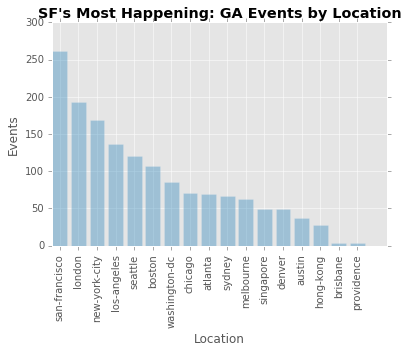

In [7]:
#Plots bar chart of events by location http://matplotlib.org/examples/pylab_examples/barchart_demo.html
def barchart(index, count, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    len_count = np.arange(len(count))
    bar_width = 0.80
    opacity = 0.4
    rects1 = plt.bar(len_count, count, bar_width, alpha=opacity)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight = "bold")
    plt.xticks(len_count + bar_width/2, index, rotation = 90)
    plt.style.use('ggplot')
    plt.show()
barchart(master_df.location.value_counts().index, master_df.location.value_counts(),"SF's Most Happening: GA Events by Location","Location","Events")

San Francisco is by far the most happening GA Campus with over 250 upcoming events. My campus, Washington DC, is right in the middle with a little less than a hundred. Providence is dead last, but in all honesty - did anyone expect a campus to be located there anyways?

One caveat to the above analysis is this includes all events listed on each location event page. This includes courses such as the Data Science Immersive Course. One could argue courses may differ from traditional events.

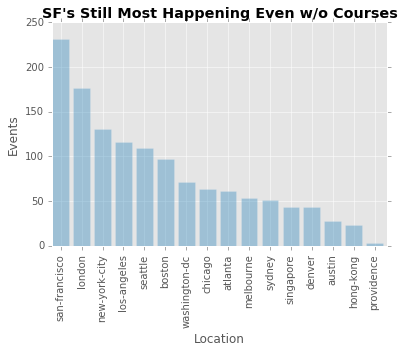

In [8]:
barchart(master_df[master_df["format"]!="course"].location.value_counts().index, master_df[master_df["format"]!="course"].location.value_counts(),"SF's Still Most Happening Even w/o Courses","Location","Events")

But even with factoring out courses, the distribution does not change very much. Except now Brisbane is last, which is a shame because I would have really liked the study abroad opportunity